In [ ]:
!pip install ucimlrepo
!pip install libsvm-official

Cross Validation Accuracy = 74.3849%
Cross Validation Accuracy = 75.5427%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 69.754%
Cross Validation Accuracy = 76.1216%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 75.8321%
Cross Validation Accuracy = 65.123%
Cross Validation Accuracy = 76.1216%
Cross Validation Accuracy = 77.5687%
Cross Validation Accuracy = 75.6874%
Cross Validation Accuracy = 75.9768%
Cross Validation Accuracy = 77.2793%
Cross Validation Accuracy = 76.7004%
Cross Validation Accuracy = 73.3719%
Cross Validation Accuracy = 75.9768%
Cross Validation Accuracy = 76.411%
Cross Validation Accuracy = 76.5557%
Cross Validation Accuracy = 76.1216%
Cross Validation Accuracy = 75.1085%
Cross Validation Accuracy = 76.8452%
Cross Validation Accuracy = 76.9899%
Cross Validation Accuracy = 75.9768%
Cross Validation Accuracy = 74.2402%
Cross Validation Accuracy = 77.424%
Cross Validation Accuracy = 76.1216%
Cross Validation Accuracy = 76.1216%
Cross V

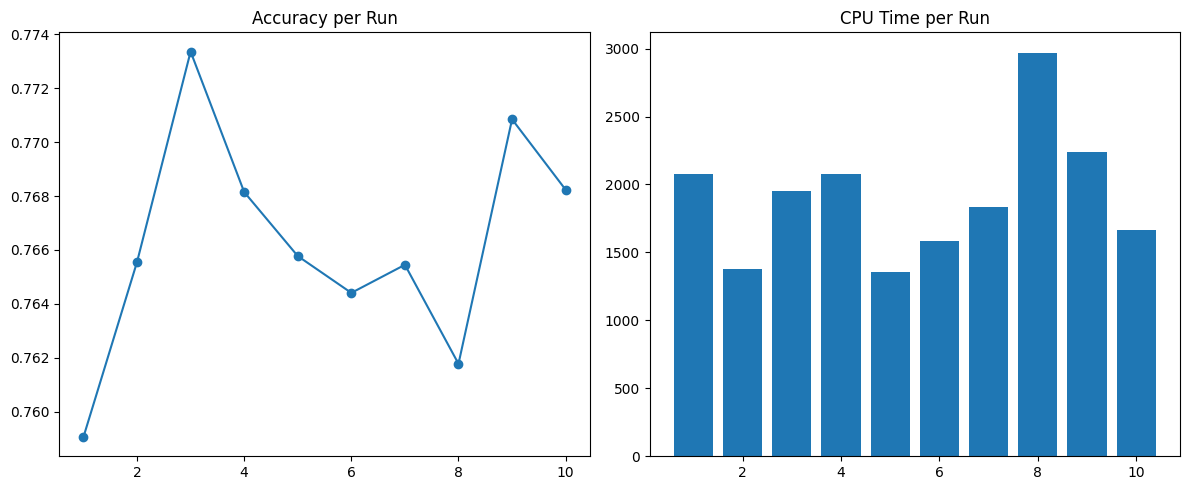

In [ ]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from libsvm.svmutil import svm_problem, svm_parameter, svm_train, svm_predict
from ucimlrepo import fetch_ucirepo

np.random.seed(42)

class CSASVM:
    def __init__(self, population_size=8, max_generations=125, clone_factor=1, alpha=0.5):
        self.population_size = population_size
        self.max_generations = max_generations
        self.clone_factor = clone_factor   
        self.alpha = alpha           

        self.C_bounds = (-5, 15)
        self.gamma_bounds = (-15, 1)

    def initialize_population(self):
        pop = []
        for _ in range(self.population_size):
            logC = np.random.uniform(*self.C_bounds)
            logG = np.random.uniform(*self.gamma_bounds)
            pop.append([logC, logG])
        return np.array(pop)

    def affinity(self, logC, logG, X, y):
        C = 2 ** logC
        gamma = 2 ** logG
        prob = svm_problem(y.tolist(), X.tolist())
        param = svm_parameter(f'-s 0 -t 2 -c {C} -g {gamma} -v 5 -q')
        acc = svm_train(prob, param)   
        return acc / 100.0

    def search(self, X, y):
        population = self.initialize_population()
        best_affinity = -np.inf
        best_solution = None

        for _ in range(self.max_generations):
            affinities = np.array([
                self.affinity(ind[0], ind[1], X, y)
                for ind in population
            ])

            # Sort by affinity (descending)
            idx = np.argsort(-affinities)
            population = population[idx]
            affinities = affinities[idx]

            # Elitism
            if affinities[0] > best_affinity:
                best_affinity = affinities[0]
                best_solution = population[0].copy()

            # Selection (top half)
            selected = population[:self.population_size // 2]
            selected_aff = affinities[:self.population_size // 2]

            clones = []
            for ind, aff in zip(selected, selected_aff):
                n_clones = self.clone_factor  
                for _ in range(n_clones):
                    clone = ind.copy()

                    sigma = self.alpha / (aff + 1e-6)
                    clone[0] += np.random.normal(0, sigma)
                    clone[1] += np.random.normal(0, sigma)
                    clone[0] = np.clip(clone[0], *self.C_bounds)
                    clone[1] = np.clip(clone[1], *self.gamma_bounds)
                    clones.append(clone)

            clones = np.array(clones)

            clone_aff = np.array([
                self.affinity(ind[0], ind[1], X, y)
                for ind in clones
            ])

            best_idx = np.argsort(-clone_aff)[:self.population_size]
            population = clones[best_idx]

        best_C = 2 ** best_solution[0]
        best_gamma = 2 ** best_solution[1]
        return best_C, best_gamma, best_affinity

    def fit(self, X, y):
        df = pd.DataFrame(X)
        df.fillna(df.mean(), inplace=True)
        X = df.values

        all_acc, all_auc, all_sens, all_spec = [], [], [], []
        run_times = []

        for run in range(10):
            outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42 + run)
            fold_times = []

            for train_idx, test_idx in outer_cv.split(X, y):
                start = time.time()

                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                scaler = MinMaxScaler((-1, 1))
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

                best_C, best_gamma, _ = self.search(X_train, y_train)

                prob = svm_problem(y_train.tolist(), X_train.tolist())
                param = svm_parameter(f'-s 0 -t 2 -c {best_C} -g {best_gamma} -b 1 -q')
                model = svm_train(prob, param)

                p_label, p_acc, p_val = svm_predict(
                    y_test.tolist(), X_test.tolist(), model, '-b 1 -q'
                )

                acc = p_acc[0] / 100
                all_acc.append(acc)

                probs = [v[0] for v in p_val]
                all_auc.append(roc_auc_score(y_test, probs))

                tn, fp, fn, tp = confusion_matrix(y_test, p_label).ravel()
                all_sens.append(tp / (tp + fn))
                all_spec.append(tn / (tn + fp))

                fold_times.append(time.time() - start)

            run_times.append(sum(fold_times))

        return {
            'acc_mean': np.mean(all_acc), 'acc_std': np.std(all_acc),
            'auc_mean': np.mean(all_auc), 'auc_std': np.std(all_auc),
            'sens_mean': np.mean(all_sens), 'sens_std': np.std(all_sens),
            'spec_mean': np.mean(all_spec), 'spec_std': np.std(all_spec),
            'run_times': run_times,
            'per_run_acc': np.array(all_acc).reshape(10, 10).mean(axis=1)
        }


# Running on Pima Indians diabetes
diabetes_data = pd.read_csv('Pima Indians diabetes (Pima).csv')
X = diabetes_data.iloc[:, :-1].values
y = diabetes_data.iloc[:, -1].values

model = CSASVM()
result = model.fit(X, y)

print(f"Accuracy: {result['acc_mean']:.4f} ± {result['acc_std']:.4f}")
print(f"AUC: {result['auc_mean']:.4f} ± {result['auc_std']:.4f}")
print(f"Sensitivity: {result['sens_mean']:.4f} ± {result['sens_std']:.4f}")
print(f"Specificity: {result['spec_mean']:.4f} ± {result['spec_std']:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,11), result['per_run_acc'], 'o-')
plt.title('Accuracy per Run')

plt.subplot(1,2,2)
plt.bar(range(1,11), result['run_times'])
plt.title('CPU Time per Run')

plt.tight_layout()
plt.show()